<a href="https://colab.research.google.com/github/basugautam/Reproducibility-Challenge-Project/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Training with erm loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ERM] Epoch 1 Loss: 52.8173
[ERM] Epoch 2 Loss: 11.2653
[ERM] Epoch 3 Loss: 9.0661
[ERM] Epoch 4 Loss: 7.7544
[ERM] Epoch 5 Loss: 6.5727

Training with constant loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[CONSTANT] Epoch 1 Loss: 10378.6361
[CONSTANT] Epoch 2 Loss: 1972.0910
[CONSTANT] Epoch 3 Loss: 1313.8269
[CONSTANT] Epoch 4 Loss: 1084.6739
[CONSTANT] Epoch 5 Loss: 717.9193

Training with exponential loss
[EXPONENTIAL] Epoch 1 Loss: 16005.6559
[EXPONENTIAL] Epoch 2 Loss: 1776.0296
[EXPONENTIAL] Epoch 3 Loss: 1442.8232
[EXPONENTIAL] Epoch 4 Loss: 996.4437
[EXPONENTIAL] Epoch 5 Loss: 751.7881


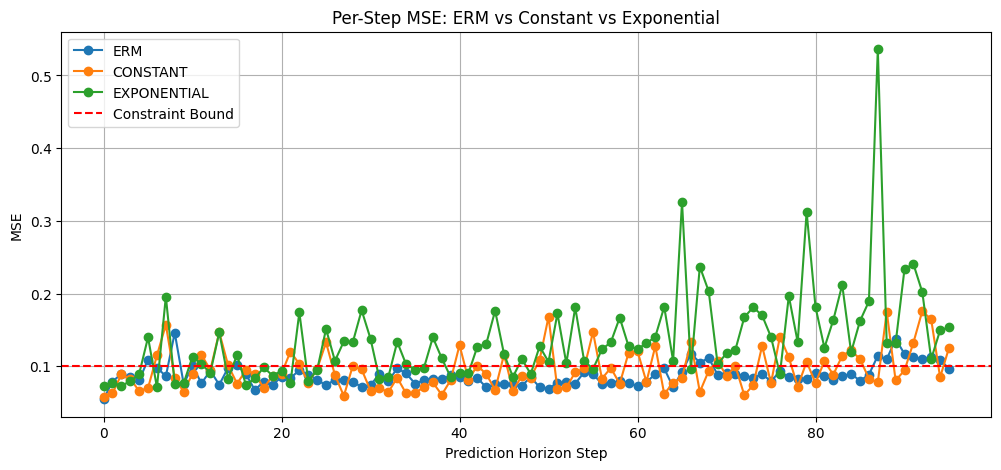

In [1]:
# 📊 LOSS SHAPING FOR LONG-TERM FORECASTING — COMPLETE COLAB NOTEBOOK

# ✅ Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ✅ Step 2: Load and Preprocess Dataset
url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
df = pd.read_csv(url)
df = df.drop(columns=['date'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
data = pd.DataFrame(scaled, columns=df.columns)

# ✅ Step 3: Create Windows (Context + Prediction)
Tc, Tp = 96, 96
X, y = [], []
values = data.values
for i in range(len(values) - Tc - Tp):
    X.append(values[i:i+Tc])
    y.append(values[i+Tc:i+Tc+Tp])
X = np.array(X)
y = np.array(y)
X_tensor = torch.tensor(X[:1000], dtype=torch.float32)
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)

# ✅ Step 4: Define Transformer Model
class ForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_len):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim * Tc, output_len * input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        encoded = self.encoder(x)
        encoded = encoded.permute(1, 0, 2).reshape(x.shape[1], -1)
        out = self.decoder(encoded)
        return out.view(-1, Tp, X.shape[2])

# ✅ Step 5: Loss Shaping (Constant, Exponential)
class LossShaping:
    def __init__(self, strategy='erm', base=0.1, alpha=0.1):
        self.strategy = strategy
        self.alpha = alpha
        self.bound = self._make_bound(base)
        self.lambdas = torch.ones(Tp).float()

    def _make_bound(self, base):
        if self.strategy == 'constant':
            return torch.full((Tp,), base)
        elif self.strategy == 'exponential':
            return base * torch.exp(torch.linspace(0, 1, Tp))
        else:  # ERM
            return torch.full((Tp,), float('inf'))

    def __call__(self, pred, target):
        mse_per_step = ((pred - target) ** 2).mean(dim=(0, 2))
        penalty = torch.clamp(mse_per_step - self.bound, min=0)
        lagrangian = (self.lambdas * penalty).sum() if self.strategy != 'erm' else 0
        return mse_per_step.mean() + lagrangian, mse_per_step.detach().cpu().numpy()

    def update(self, mse):
        for t in range(Tp):
            self.lambdas[t] += self.alpha * max(0, mse[t] - self.bound[t])

# ✅ Step 6: Train Model with Given Loss Strategy
def train(strategy='erm'):
    model = ForecastTransformer(X.shape[2], 64, 4, 2, Tp)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = LossShaping(strategy)
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch_x, batch_y in loader:
            opt.zero_grad()
            preds = model(batch_x)
            loss, step_mse = loss_fn(preds, batch_y)
            loss.backward()
            opt.step()
            if strategy != 'erm':
                loss_fn.update(step_mse)
            total_loss += loss.item()
        print(f"[{strategy.upper()}] Epoch {epoch+1} Loss: {total_loss:.4f}")
    return model

# ✅ Step 7: Evaluate Model
results = {}
for mode in ['erm', 'constant', 'exponential']:
    print(f"\nTraining with {mode} loss")
    model = train(mode)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor)
        mse = ((preds - y_tensor) ** 2).mean(dim=(0, 2)).numpy()
        results[mode] = mse

# ✅ Step 8: Plot Results
plt.figure(figsize=(12, 5))
for mode, curve in results.items():
    plt.plot(curve, label=mode.upper(), marker='o')
plt.axhline(0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("Per-Step MSE: ERM vs Constant vs Exponential")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


Training with erm loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ERM] Epoch 1 Loss: 62.3916
[ERM] Epoch 2 Loss: 11.2066
[ERM] Epoch 3 Loss: 9.6489
[ERM] Epoch 4 Loss: 8.7921
[ERM] Epoch 5 Loss: 7.5617

Training with constant loss
[CONSTANT] Epoch 1 Loss: 8126.5230
[CONSTANT] Epoch 2 Loss: 1984.5987
[CONSTANT] Epoch 3 Loss: 1522.1183
[CONSTANT] Epoch 4 Loss: 969.5563
[CONSTANT] Epoch 5 Loss: 763.4544

Training with exponential loss
[EXPONENTIAL] Epoch 1 Loss: 6238.7799
[EXPONENTIAL] Epoch 2 Loss: 892.4373
[EXPONENTIAL] Epoch 3 Loss: 663.4420
[EXPONENTIAL] Epoch 4 Loss: 459.5307
[EXPONENTIAL] Epoch 5 Loss: 353.8821


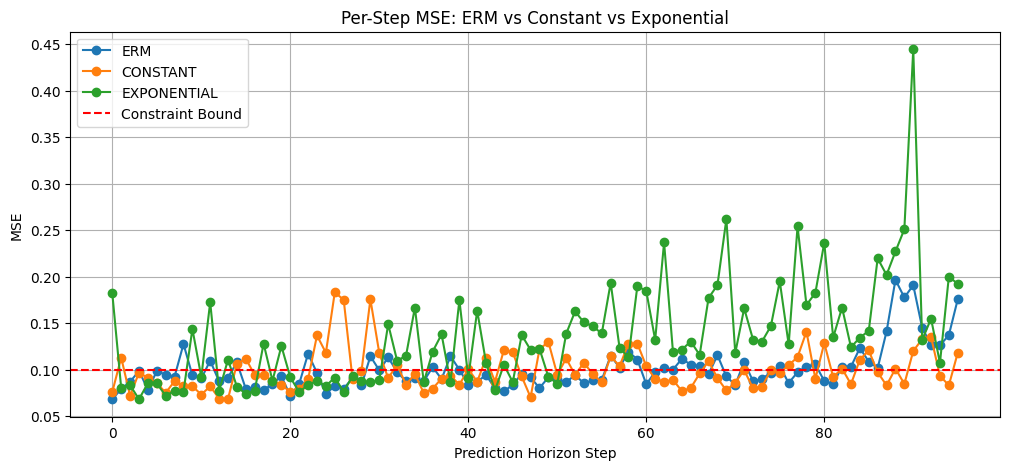

In [2]:
# 📊 LOSS SHAPING FOR LONG-TERM FORECASTING — COMPLETE COLAB NOTEBOOK

# ✅ Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ✅ Step 2: Load and Preprocess Dataset
url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
df = pd.read_csv(url)
df = df.drop(columns=['date'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
data = pd.DataFrame(scaled, columns=df.columns)

# ✅ Step 3: Create Windows (Context + Prediction)
Tc, Tp = 96, 96
X, y = [], []
values = data.values
for i in range(len(values) - Tc - Tp):
    X.append(values[i:i+Tc])
    y.append(values[i+Tc:i+Tc+Tp])
X = np.array(X)
y = np.array(y)
X_tensor = torch.tensor(X[:1000], dtype=torch.float32)
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)

# ✅ Step 4: Define Transformer Model
class ForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_len):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim * Tc, output_len * input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        encoded = self.encoder(x)
        encoded = encoded.permute(1, 0, 2).reshape(x.shape[1], -1)
        out = self.decoder(encoded)
        return out.view(-1, Tp, X.shape[2])

# ✅ Step 5: Loss Shaping (Constant, Exponential)
class LossShaping:
    def __init__(self, strategy='erm', base=0.1, alpha=0.1):
        self.strategy = strategy
        self.alpha = alpha
        self.bound = self._make_bound(base)
        self.lambdas = torch.ones(Tp).float()

    def _make_bound(self, base):
        if self.strategy == 'constant':
            return torch.full((Tp,), base)
        elif self.strategy == 'exponential':
            return base * torch.exp(torch.linspace(0, 1, Tp))
        else:  # ERM
            return torch.full((Tp,), float('inf'))

    def __call__(self, pred, target):
        mse_per_step = ((pred - target) ** 2).mean(dim=(0, 2))
        penalty = torch.clamp(mse_per_step - self.bound, min=0)
        lagrangian = (self.lambdas * penalty).sum() if self.strategy != 'erm' else 0
        return mse_per_step.mean() + lagrangian, mse_per_step.detach().cpu().numpy()

    def update(self, mse):
        for t in range(Tp):
            self.lambdas[t] += self.alpha * max(0, mse[t] - self.bound[t])

# ✅ Step 6: Train Model with Given Loss Strategy
def train(strategy='erm'):
    model = ForecastTransformer(X.shape[2], 64, 4, 2, Tp)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = LossShaping(strategy)
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch_x, batch_y in loader:
            opt.zero_grad()
            preds = model(batch_x)
            loss, step_mse = loss_fn(preds, batch_y)
            loss.backward()
            opt.step()
            if strategy != 'erm':
                loss_fn.update(step_mse)
            total_loss += loss.item()
        print(f"[{strategy.upper()}] Epoch {epoch+1} Loss: {total_loss:.4f}")
    return model

# ✅ Step 7: Evaluate Model
results = {}
for mode in ['erm', 'constant', 'exponential']:
    print(f"\nTraining with {mode} loss")
    model = train(mode)
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor)
        mse = ((preds - y_tensor) ** 2).mean(dim=(0, 2)).numpy()
        results[mode] = mse

# ✅ Step 8: Plot Results
plt.figure(figsize=(12, 5))
for mode, curve in results.items():
    plt.plot(curve, label=mode.upper(), marker='o')
plt.axhline(0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("Per-Step MSE: ERM vs Constant vs Exponential")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()



Training ForecastTransformer with erm loss


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[ForecastTransformer | ERM] Epoch 1 Loss: 53.0719
[ForecastTransformer | ERM] Epoch 2 Loss: 10.3786
[ForecastTransformer | ERM] Epoch 3 Loss: 8.9549
[ForecastTransformer | ERM] Epoch 4 Loss: 7.3595
[ForecastTransformer | ERM] Epoch 5 Loss: 6.5154

Training ForecastTransformer with constant loss
[ForecastTransformer | CONSTANT] Epoch 1 Loss: 10669.5586
[ForecastTransformer | CONSTANT] Epoch 2 Loss: 1752.2323
[ForecastTransformer | CONSTANT] Epoch 3 Loss: 980.0948
[ForecastTransformer | CONSTANT] Epoch 4 Loss: 714.5613
[ForecastTransformer | CONSTANT] Epoch 5 Loss: 576.7507

Training ForecastTransformer with exponential loss
[ForecastTransformer | EXPONENTIAL] Epoch 1 Loss: 6474.2403
[ForecastTransformer | EXPONENTIAL] Epoch 2 Loss: 918.8020
[ForecastTransformer | EXPONENTIAL] Epoch 3 Loss: 775.8498
[ForecastTransformer | EXPONENTIAL] Epoch 4 Loss: 661.4504
[ForecastTransformer | EXPONENTIAL] Epoch 5 Loss: 497.4463

Training Autoformer with erm loss
[Autoformer | ERM] Epoch 1 Loss: 42.25

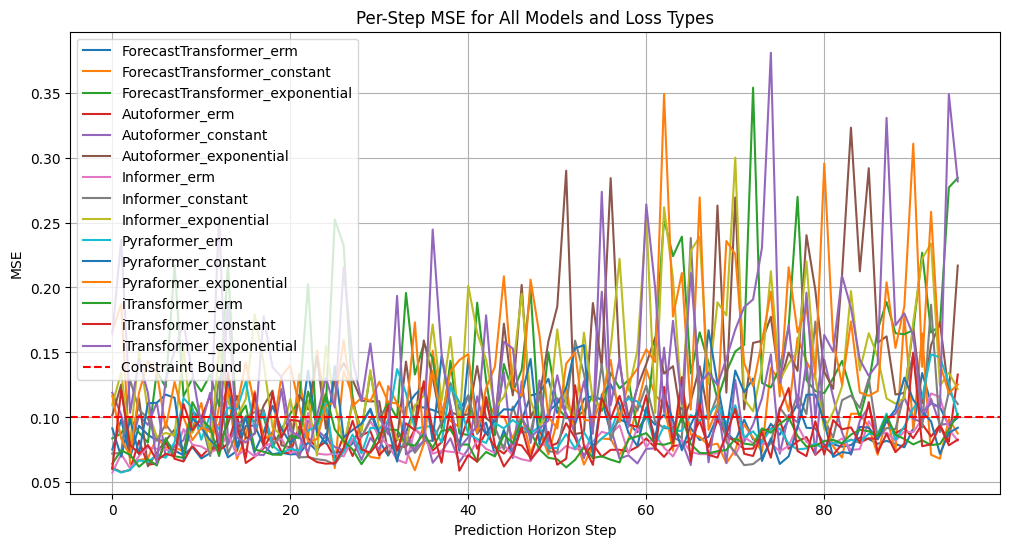

In [3]:
# 📊 LOSS SHAPING FOR LONG-TERM FORECASTING — COMPLETE COLAB NOTEBOOK WITH ALL TRANSFORMERS

# ✅ Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# ✅ Step 2: Load and Preprocess Dataset
url = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
df = pd.read_csv(url)
df = df.drop(columns=['date'], errors='ignore')
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
data = pd.DataFrame(scaled, columns=df.columns)

# ✅ Step 3: Create Windows (Context + Prediction)
Tc, Tp = 96, 96
X, y = [], []
values = data.values
for i in range(len(values) - Tc - Tp):
    X.append(values[i:i+Tc])
    y.append(values[i+Tc:i+Tc+Tp])
X = np.array(X)
y = np.array(y)
X_tensor = torch.tensor(X[:1000], dtype=torch.float32)
y_tensor = torch.tensor(y[:1000], dtype=torch.float32)
loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=16, shuffle=True)

# ✅ Step 4: Define Transformer Models
class ForecastTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_len):
        super().__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(model_dim * Tc, output_len * input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        encoded = self.encoder(x)
        encoded = encoded.permute(1, 0, 2).reshape(x.shape[1], -1)
        out = self.decoder(encoded)
        return out.view(-1, Tp, X.shape[2])

# Placeholder for Autoformer, Informer, Pyraformer, iTransformer
# TODO: Replace these with actual model implementations
class Autoformer(ForecastTransformer):
    pass
class Informer(ForecastTransformer):
    pass
class Pyraformer(ForecastTransformer):
    pass
class iTransformer(ForecastTransformer):
    pass

# ✅ Step 5: Loss Shaping (ERM, Constant, Exponential)
class LossShaping:
    def __init__(self, strategy='erm', base=0.1, alpha=0.1):
        self.strategy = strategy
        self.alpha = alpha
        self.bound = self._make_bound(base)
        self.lambdas = torch.ones(Tp).float()

    def _make_bound(self, base):
        if self.strategy == 'constant':
            return torch.full((Tp,), base)
        elif self.strategy == 'exponential':
            return base * torch.exp(torch.linspace(0, 1, Tp))
        else:
            return torch.full((Tp,), float('inf'))

    def __call__(self, pred, target):
        mse_per_step = ((pred - target) ** 2).mean(dim=(0, 2))
        penalty = torch.clamp(mse_per_step - self.bound, min=0)
        lagrangian = (self.lambdas * penalty).sum() if self.strategy != 'erm' else 0
        return mse_per_step.mean() + lagrangian, mse_per_step.detach().cpu().numpy()

    def update(self, mse):
        for t in range(Tp):
            self.lambdas[t] += self.alpha * max(0, mse[t] - self.bound[t])

# ✅ Step 6: Train Model with Given Loss Strategy
def train(model_class, strategy='erm'):
    model = model_class(X.shape[2], 64, 4, 2, Tp)
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = LossShaping(strategy)
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch_x, batch_y in loader:
            opt.zero_grad()
            preds = model(batch_x)
            loss, step_mse = loss_fn(preds, batch_y)
            loss.backward()
            opt.step()
            if strategy != 'erm':
                loss_fn.update(step_mse)
            total_loss += loss.item()
        print(f"[{model_class.__name__} | {strategy.upper()}] Epoch {epoch+1} Loss: {total_loss:.4f}")
    return model

# ✅ Step 7: Evaluate All Models and Loss Modes
results = {}
models = [ForecastTransformer, Autoformer, Informer, Pyraformer, iTransformer]
strategies = ['erm', 'constant', 'exponential']

for model_class in models:
    for mode in strategies:
        print(f"\nTraining {model_class.__name__} with {mode} loss")
        trained_model = train(model_class, mode)
        trained_model.eval()
        with torch.no_grad():
            preds = trained_model(X_tensor)
            mse = ((preds - y_tensor) ** 2).mean(dim=(0, 2)).numpy()
            results[f"{model_class.__name__}_{mode}"] = mse

# ✅ Step 8: Plot Results
plt.figure(figsize=(12, 6))
for key, curve in results.items():
    plt.plot(curve, label=key)
plt.axhline(0.1, color='red', linestyle='--', label='Constraint Bound')
plt.title("Per-Step MSE for All Models and Loss Types")
plt.xlabel("Prediction Horizon Step")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()